# Dictionary Initialization

In [3]:
daily_log_likelihoods = {}
daily_regrets = {}

# collections for plotting charts about the performance of the RW predictor
ewMeanRegretValues = []
ewMeanlogLikelihoodValues = []

# Import Data

First date of training dataset:  2010-01-04 00:00:00
Last date of training dataset:  2019-02-08 00:00:00
len of training dataset:  2291

First date of validation dataset:  2019-02-11 00:00:00
Last date of validation dataset:  2021-09-14 00:00:00
len of validation dataset:  654

First date of test dataset:  2021-09-15 00:00:00
Last date of test dataset:  2022-12-30 00:00:00
len of test dataset:  327

total dataset lenght:  3272
sum of the three datasets:  3272
original returns dataframe dimension: (3272, 3)


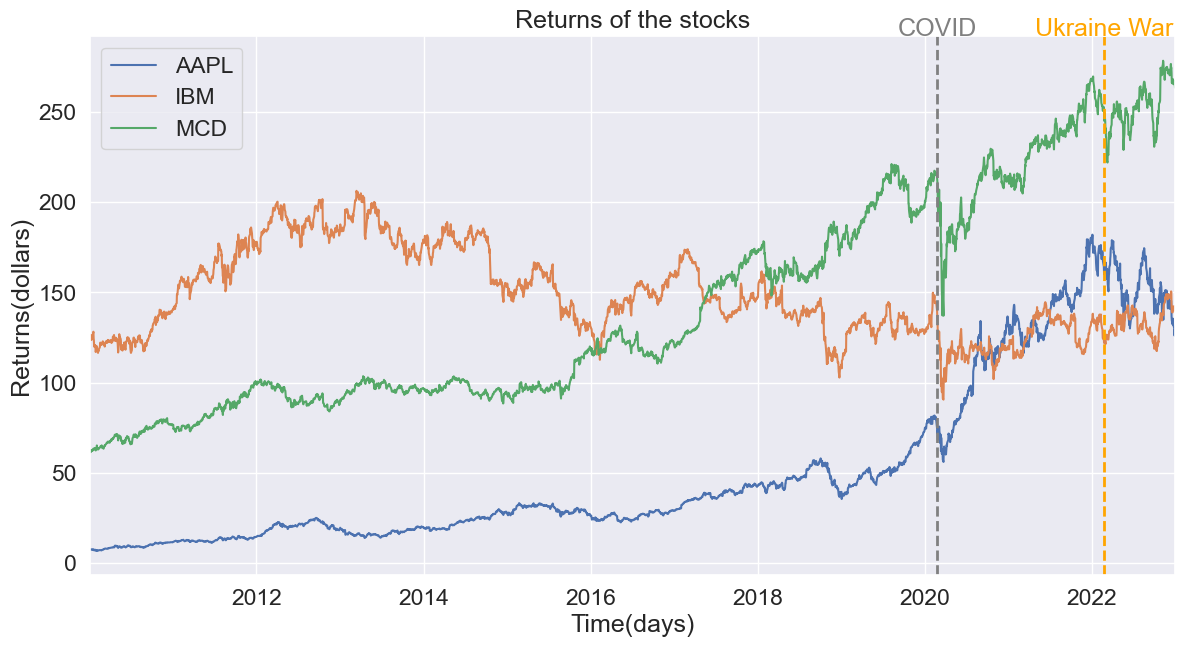

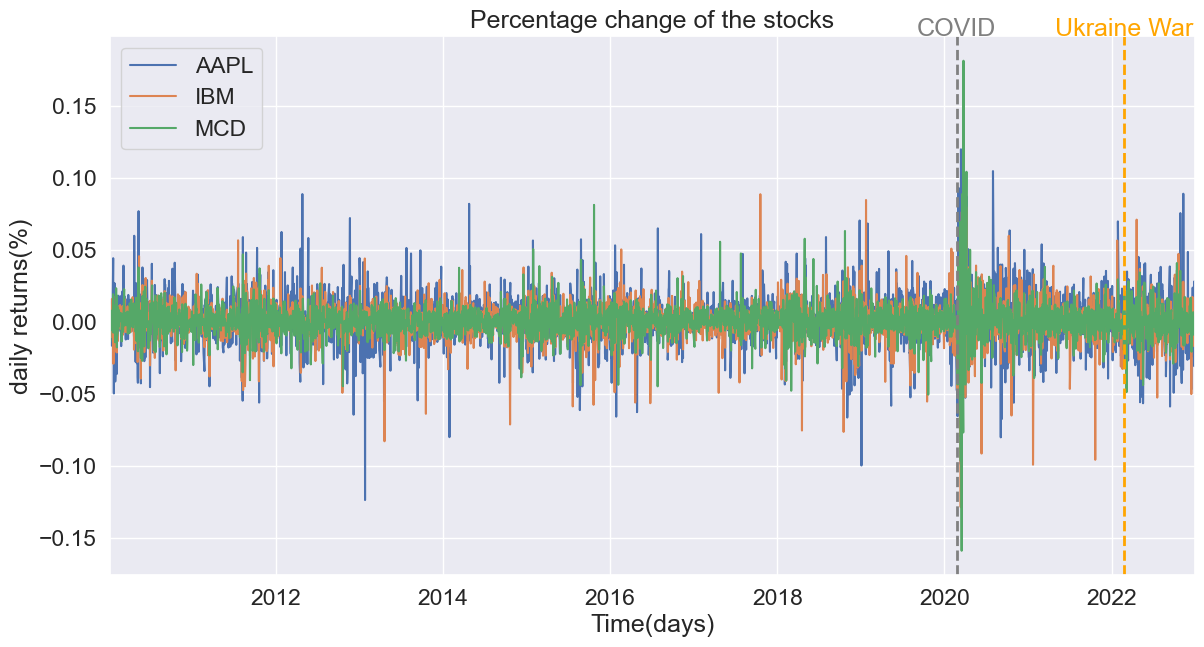

2010-01-04 00:00:00           7         20990     21177
7      0.000301  0.000114  0.000060
20990  0.000114  0.000102  0.000041
21177  0.000060  0.000041  0.000071
2010-01-05 00:00:00           7         20990     21177
7      0.000301  0.000114  0.000060
20990  0.000114  0.000102  0.000041
21177  0.000060  0.000041  0.000071
2010-01-06 00:00:00           7         20990     21177
7      0.000301  0.000114  0.000060
20990  0.000114  0.000102  0.000041
21177  0.000060  0.000041  0.000071
2010-01-07 00:00:00           7         20990     21177
7      0.000301  0.000114  0.000060
20990  0.000114  0.000102  0.000041
21177  0.000060  0.000041  0.000071
2010-01-08 00:00:00           7         20990     21177
7      0.000301  0.000114  0.000060
20990  0.000114  0.000102  0.000041
21177  0.000060  0.000041  0.000071
dimension of the prescient dictionary: 3272
2010-01-04 00:00:00
          7         20990     21177
7      0.000301  0.000114  0.000060
20990  0.000114  0.000102  0.000041
21177  0

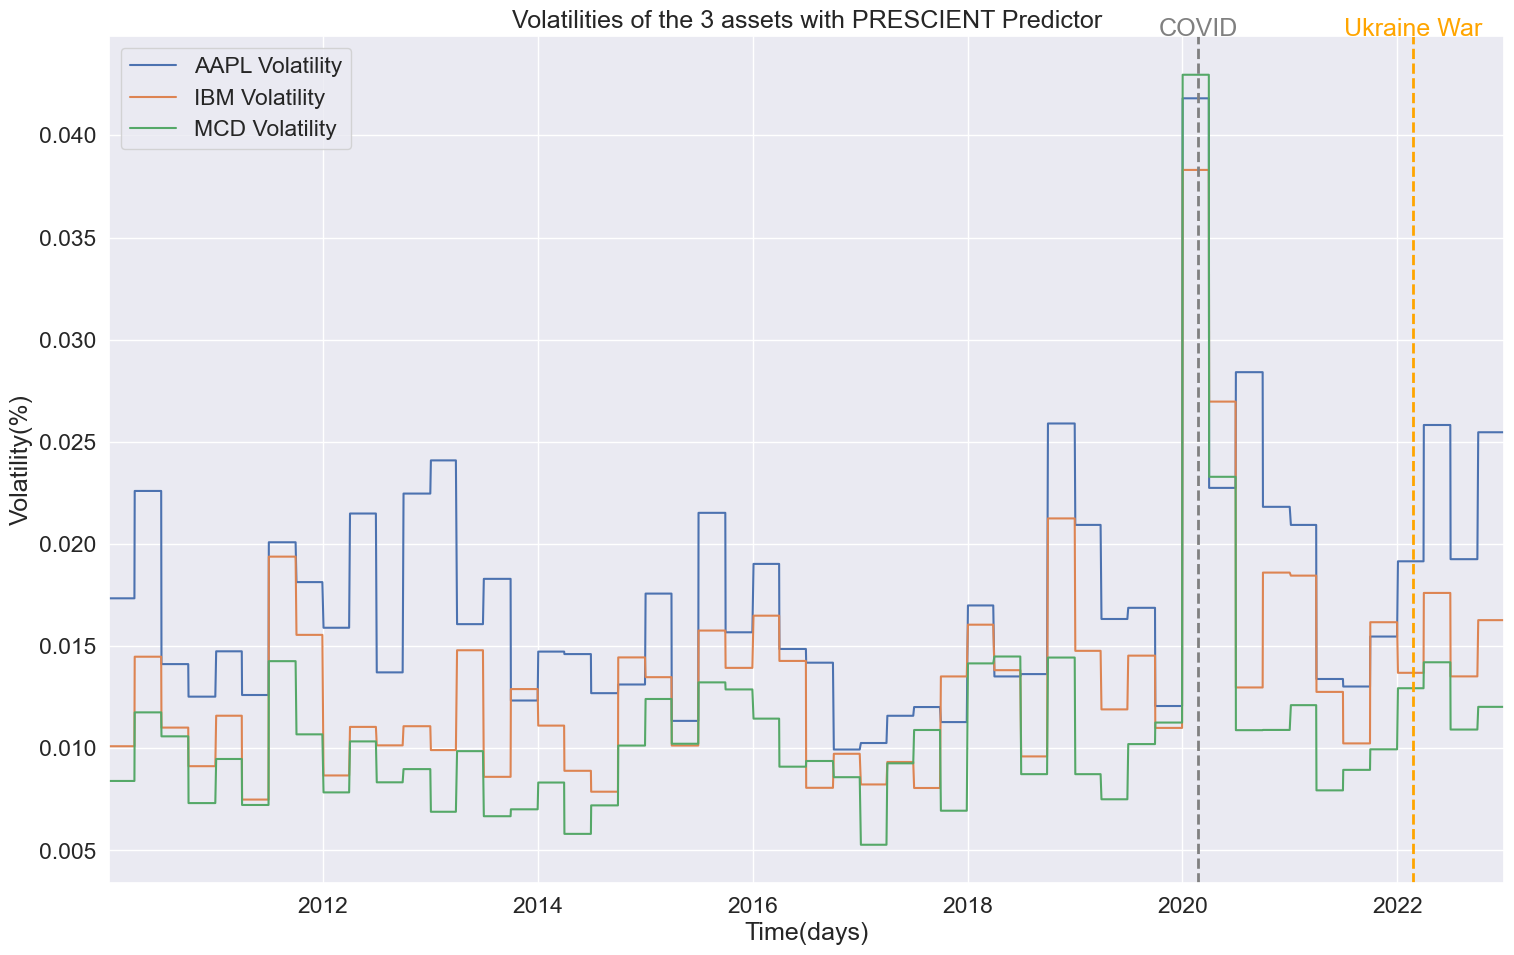

In [4]:
from predictorStarter import * # this file contains the import of every dataset, libraries needed and the initial plotting of the data
from predictorsImplementation import * # this file contains the implementation of the predictors ( one function implementation for each predictor)

# Validation Phase for expanding window predictor

ok everything works fine; at the moment i will not tune the model(there aren't parameters or hyperparameters), i just measure its performance. so i will use just the test dataset in order to have a fair evaluation of the model with respect to the performance of the other models(RW,EWMA,MGARCH) 

# Test Phase for expanding window predictor

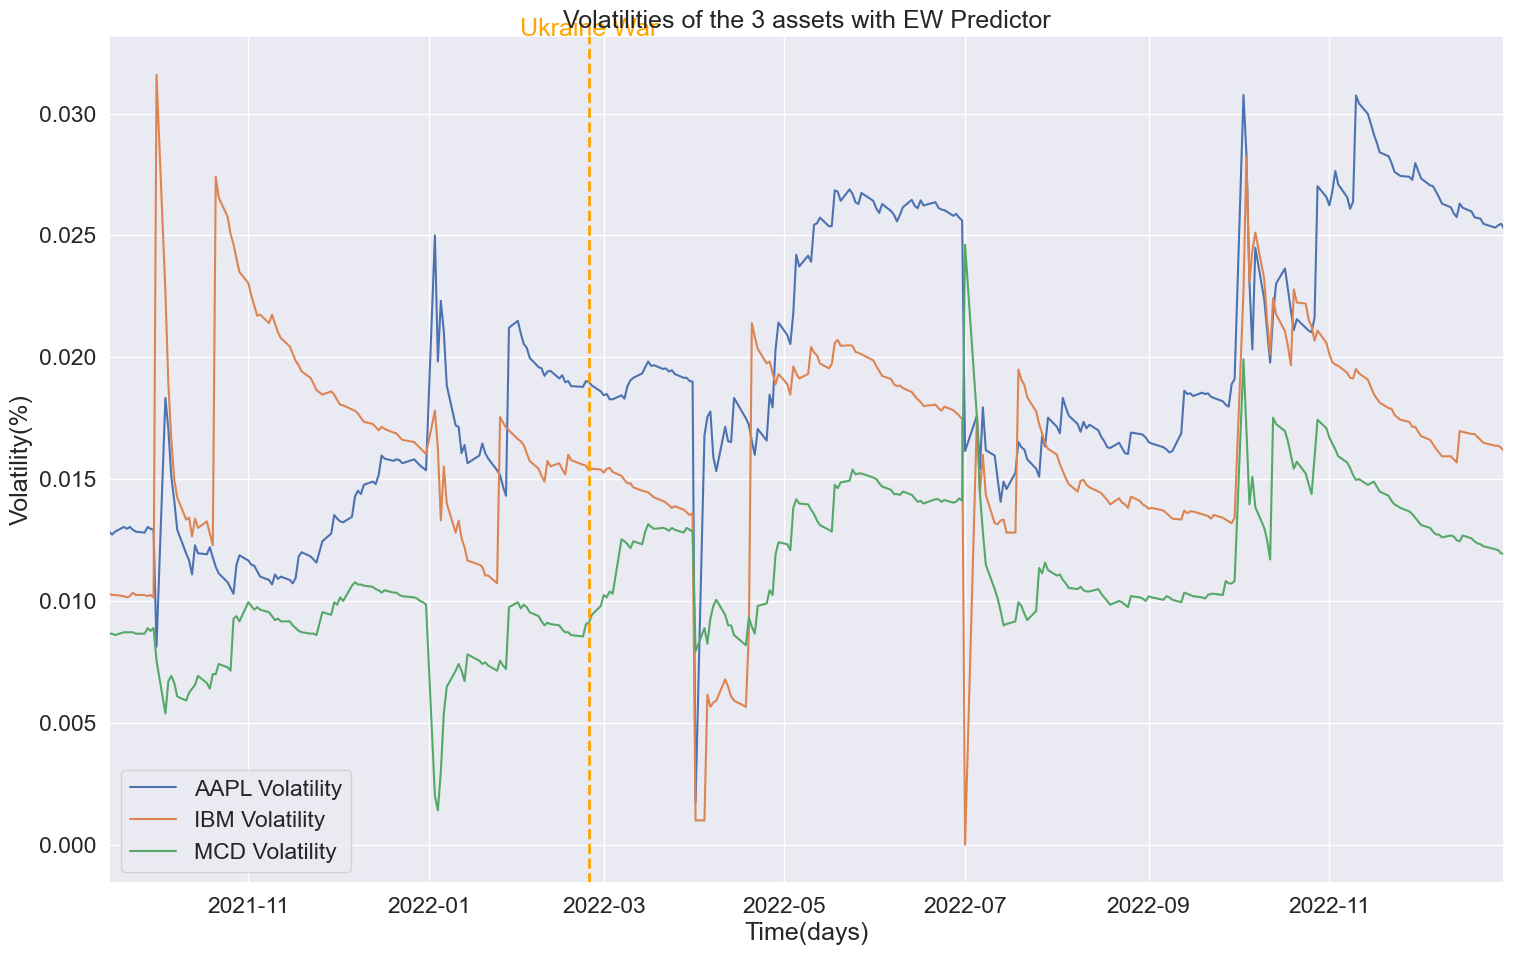

In [5]:
# prepare the date for the test phase
startingTestDate = testDataWithPercentageChange.index[0].strftime("%Y-%m-%d")
endingTestDate = testDataWithPercentageChange.index[-1].strftime("%Y-%m-%d")

# now filter the ewma volatilities between the start and end date
real_volatility_startDate = pd.to_datetime(startingTestDate)
real_volatility_endDate = pd.to_datetime(endingTestDate)

df_ew_volatility_aapl, df_ew_volatility_ibm, df_ew_volatility_mcd, ew_volatility_dict_aapl, ew_volatility_dict_ibm, ew_volatility_dict_mcd = plot_volatility(expandingWindowDict, real_volatility_startDate, real_volatility_endDate, 'EW')

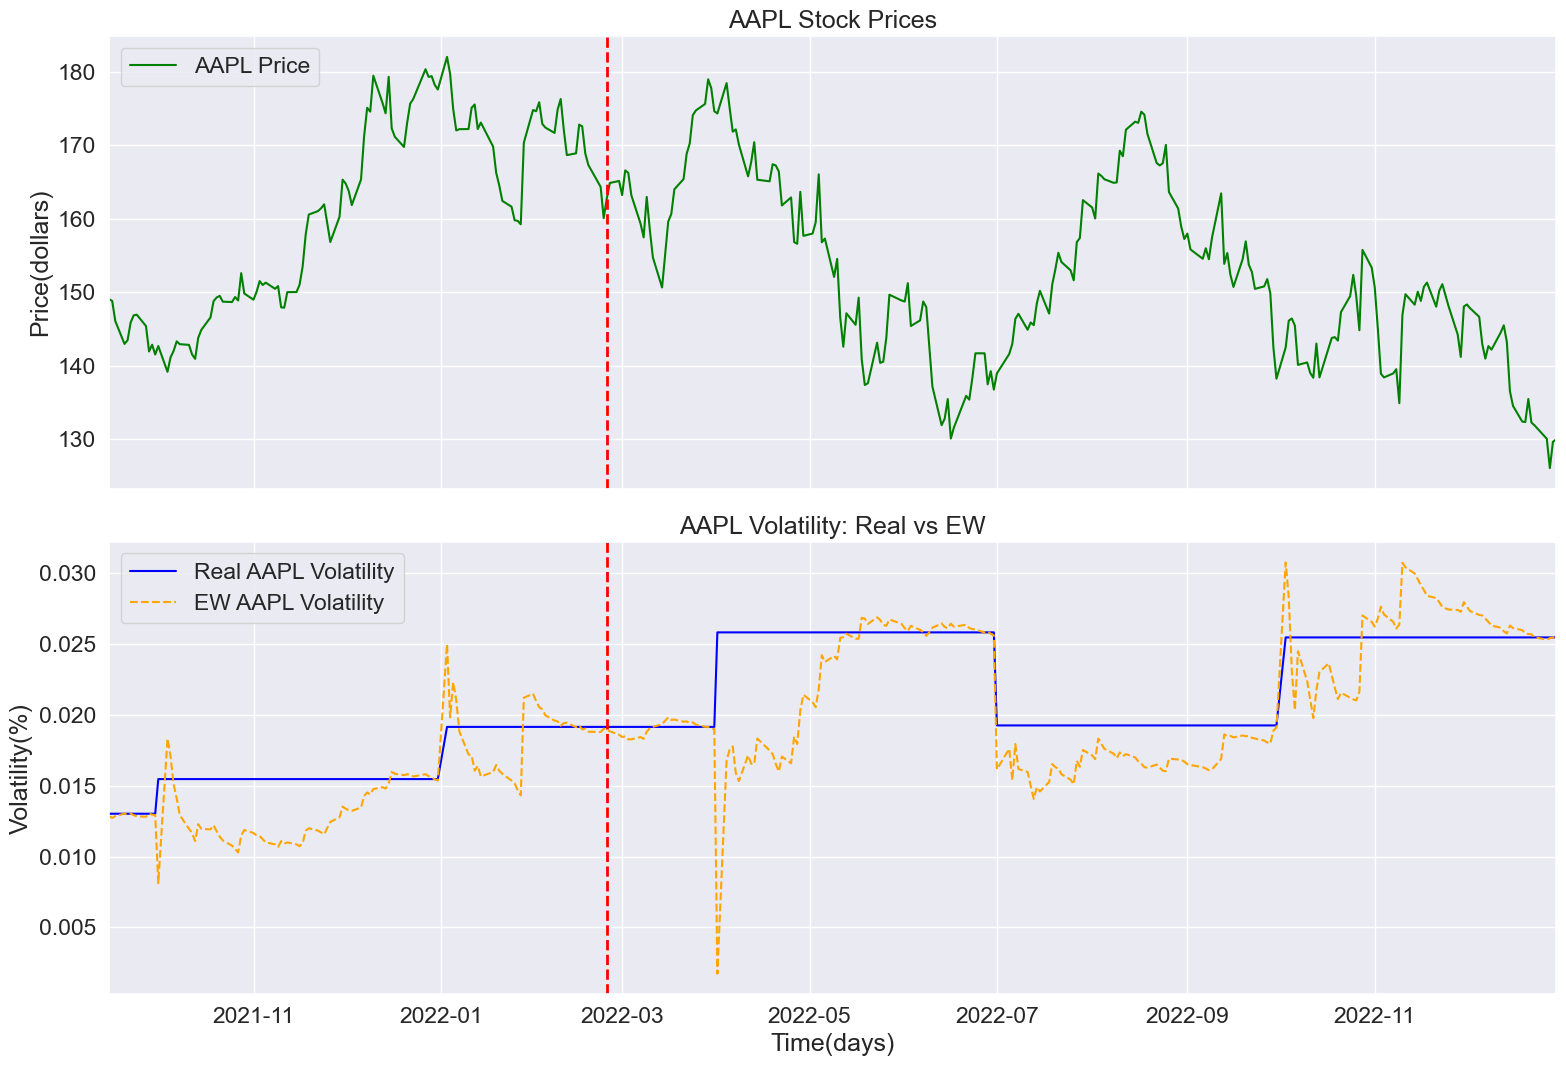

In [6]:
# HERE THERE IS THE VOLATILITY ANALYSIS OF THE EWMA PREDICTOR COMPARED TO THE REAL VOLATILITY
startDateFilter = testDataWithPrices.index[0]
endDateFilter = testDataWithPrices.index[-1]

plot_prices_volatilities_for_predictor(testDataWithPrices, df_volatility_aapl['AAPL Volatility'], startDateFilter, endDateFilter, df_ew_volatility_aapl['AAPL Volatility'], 'AAPL', "EW")

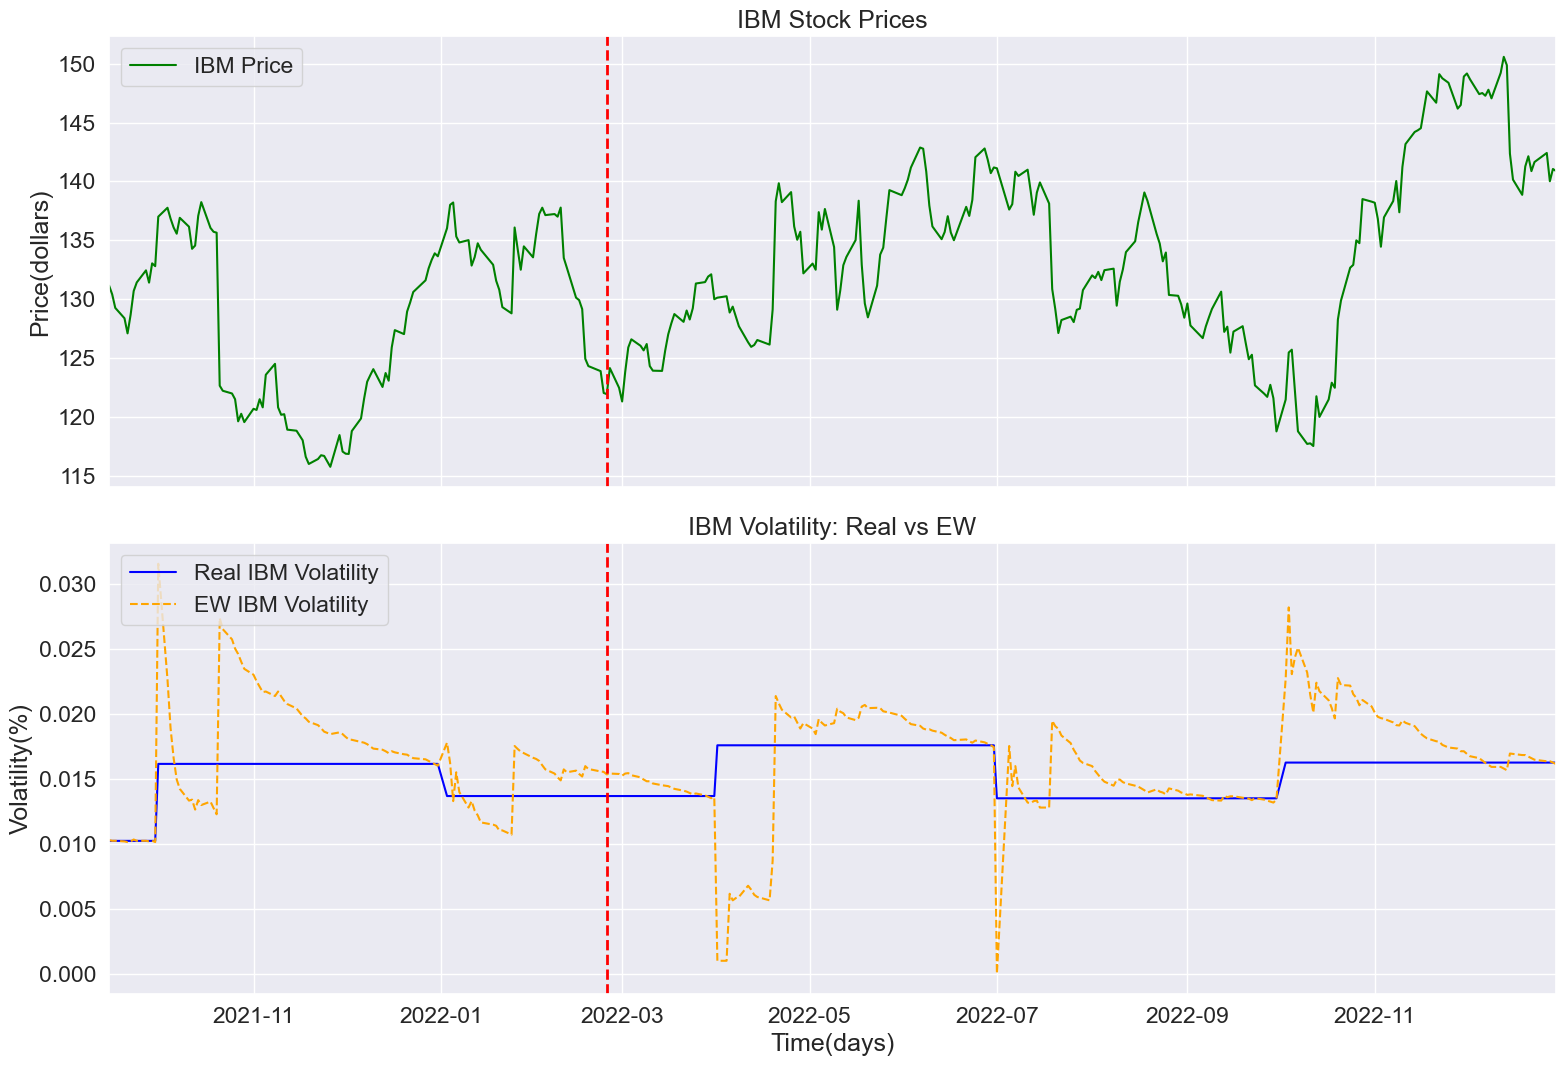

In [7]:
plot_prices_volatilities_for_predictor(testDataWithPrices, df_volatility_ibm['IBM Volatility'], startDateFilter, endDateFilter, df_ew_volatility_ibm['IBM Volatility'], 'IBM', "EW")

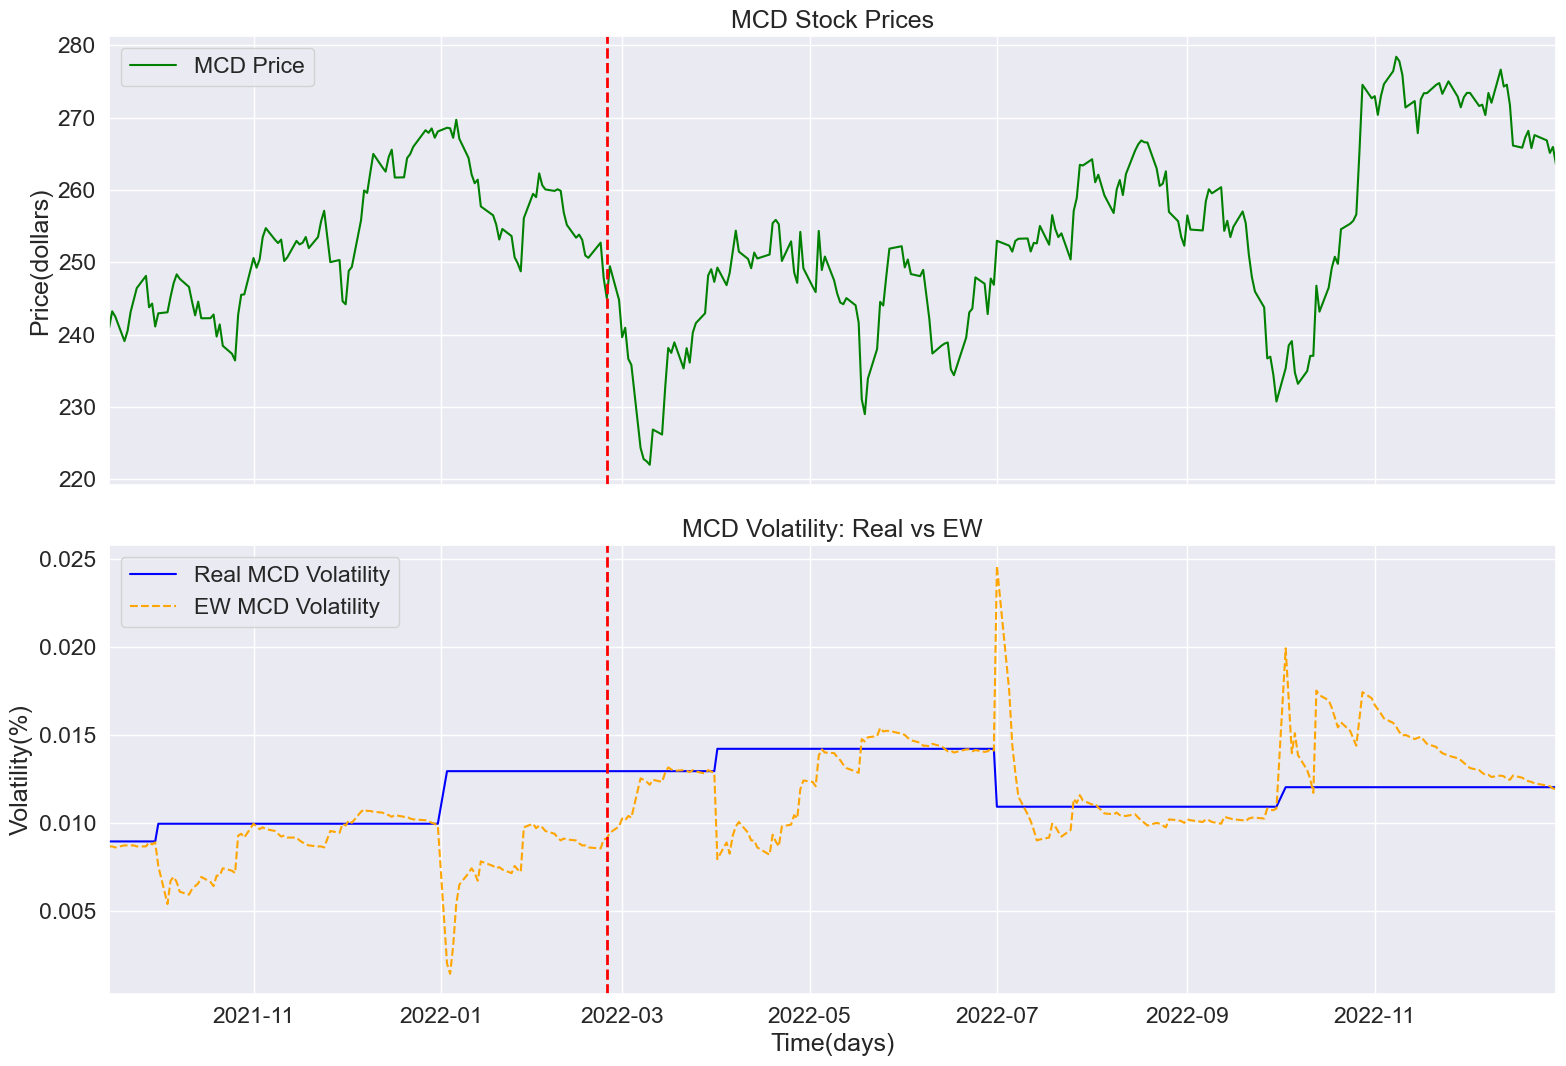

In [8]:
plot_prices_volatilities_for_predictor(testDataWithPrices, df_volatility_mcd['MCD Volatility'], startDateFilter, endDateFilter, df_ew_volatility_mcd['MCD Volatility'], 'MCD', "EW")

size of the first predictor: 308
size of the second predictor: 308
first timestamp of the first predictor: 2021-10-12 00:00:00
first timestamp of the second predictor: 2021-10-12 00:00:00


c:\Users\chiod\Desktop\MyData\universita\tesi\openSourceImplementations\cov_pred_finance\experiments\utils\experiment_utils.py:346: RuntimeWarning: invalid value encountered in log
  -n / 2 * np.log(2 * np.pi) - 1 / 2 * np.log(dets) - 1/2


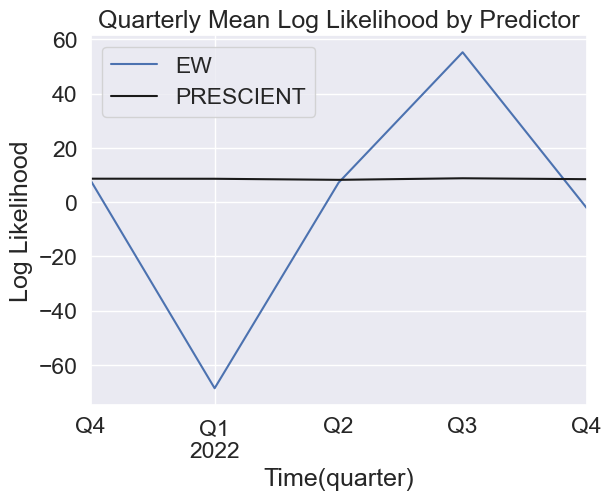



meanRegret: 8.600
stdRegret: 39.700
maxRegret: 77.300


meanLoglikelihoodEW: -0.100
stdLoglikelihoodEW: 39.700
maxLoglikelihoodEW: 55.300


meanLoglikelihoodPRESCIENT: 8.500
stdLoglikelihoodPRESCIENT: 0.200
maxLoglikelihoodPRESCIENT: 8.800

EW MSE
mean: 0.0000019203
std: 0.0000008828
max: 0.0000031789


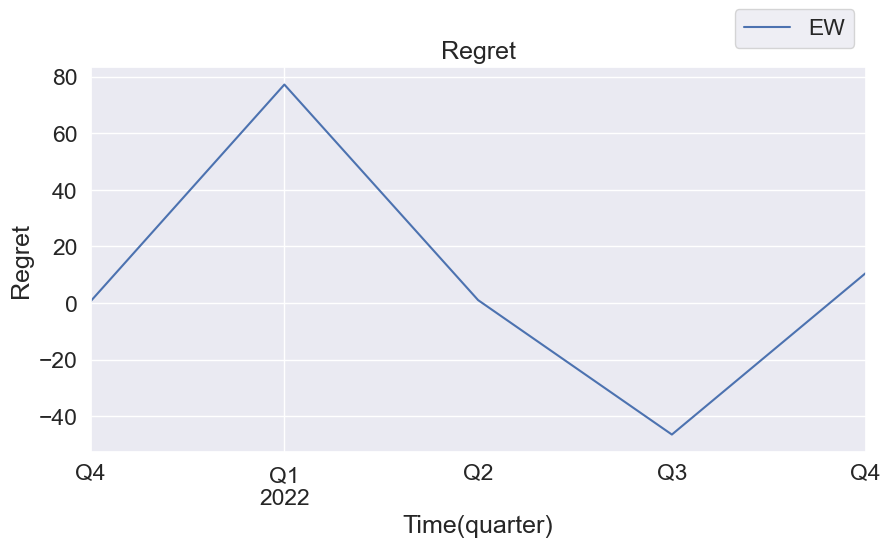

In [9]:
# NOW I DO THE LAST THING; THE COMPARISON BETWEEN THE RW PREDICTOR AND THE PRESCIENT PREDICTOR IN TERMS OF 
# LOGLIKELIHOOD, LOGLIKELIHOOD REGRET AND MSE

# first of all define the starting and ending date for the test phase: take the first and the last date of the test dataset

startingTestDate = testDataWithPercentageChange.index[0].strftime("%Y-%m-%d")
endingTestDate = testDataWithPercentageChange.index[-1].strftime("%Y-%m-%d")

start_date = pd.to_datetime(startingTestDate, format="%Y-%m-%d")
end_date = pd.to_datetime(endingTestDate, format="%Y-%m-%d")

names = ["EW", "PRESCIENT"]

#these predictors are all dictionaries where each entry contains a Pandas DataFrame representing a covariance matrix of returns at each timestamp.  
predictors_temp = [expandingWindowDict, prescientDict]
predictors = [] # so this is a list of dictionaries

for predictor in predictors_temp:
    predictors.append({t: predictor[t] for t in predictor.keys() if t >= start_date and t <= end_date})


expandingWindowDict = predictors[0]
expandingWindowDict = {k: expandingWindowDict[k] for k in list(expandingWindowDict)[19:]}
predictors[0] = expandingWindowDict

# now remove the first 19 entries from the predictor 1(prescient dict)
prescientDict = predictors[1]

# now remove the first 19 entries from the prescient dict
prescientDict = {k: prescientDict[k] for k in list(prescientDict)[19:]}
predictors[1] = prescientDict

print("size of the first predictor: " + str(len(predictors[0])))
print("size of the second predictor: " + str(len(predictors[1])))


# make an assert to check if the length of the two predictors is the same
assert len(predictors[0]) == len(predictors[1])

# make an assert to check if the timestamps of the two predictors are the same
assert predictors[0].keys() == predictors[1].keys()

# print the first timestamp of the two predictors
print("first timestamp of the first predictor: " + str(list(predictors[0].keys())[0]))
print("first timestamp of the second predictor: " + str(list(predictors[1].keys())[0]))

# if we are here, it means that the two predictors have the same length and the same timestamps so i can measure the performance of the two predictors


#
# LOG-LIKELIHOODS
#

'''
    this dictionary has a shape like this:
    {
        RW: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
        EWMA: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
        MGARCH: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
        PRESCIENT: pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times),
    }

    where each pd.series is a series of log-likelihoods for each timestamp: so there is the log-likelihood value for each timestamp
'''

log_likelihoods = {}
for i, predictorDict in enumerate(predictors):

    # if the predictor is the prescient predictor, i have to use the uniformly distributed dataset
    if names[i] == "PRESCIENT":
        returns_temp = uniformlyDistributedReturns.loc[pd.Series(predictorDict).index].values[1:]
    
    else:
        returns_temp = testDataWithPercentageChange.loc[pd.Series(predictorDict).index].values[1:]

    times = pd.Series(predictorDict).index[1:]
    Sigmas_temp = np.stack([predictorDict[t].values for t in predictorDict.keys()])[:-1]       
    log_likelihoods[names[i]] = pd.Series(log_likelihood(returns_temp, Sigmas_temp), index=times)

# Iterate through each predictor in the log_likelihoods dictionary
for name in log_likelihoods.keys():
    if name == 'PRESCIENT':
        # Resample by quarter, take the mean, and plot with specific color and label
        log_likelihoods[name].resample("Q").mean().plot(label=name, c="k")
    else:
        # Resample by quarter, take the mean, and plot with default settings
        log_likelihoods[name].resample("Q").mean().plot(label=name)

plt.xlabel('Time(quarter)')  # Set the x-axis label
plt.ylabel('Log Likelihood')  # Set the y-axis label
plt.title('Quarterly Mean Log Likelihood by Predictor')  # Set the title of the plot
plt.legend()  # Show the legend to identify each predictor
plt.show()  # Display the plot

'''
    this dictionary has a shape like this:
    {
        RW: pd.Series(...),
        EWMA: pd.Series(...),
        MGARCH: pd.Series(...),
        PRESCIENT: pd.Series(...),
    }

    where each pd.series is a series of regret for each timestamp: so there is the 
    regret value (the difference between the log-likelihood of the prescient model and the log-likelihood of the model) for each timestamp
'''
regrets = {}
for name in log_likelihoods:
    regrets[name] =  log_likelihoods["PRESCIENT"] - log_likelihoods[name]


fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for name in names:
    if name == 'PRESCIENT':
        pass
    else:
        regrets[name].resample("Q").mean().plot(label=name)
plt.legend(bbox_to_anchor=(1, 1.1), loc='center right', ncols=4, labels=names[:-1], scatterpoints=1, markerscale=5);
plt.xlabel("Time(quarter)") 
plt.ylabel("Regret")
plt.title("Regret")

for name in regrets:
    if name != "PRESCIENT":

        #Each data point in the regret series now represents the average regret for a respective quarter. If the original series spans multiple years, then the number of data points in regret will be the number of quarters in that time frame.
        regret = regrets[name].resample("Q").mean() #it resamples the regret Series to a quarterly frequency, This gives the average regret for each quarter rather than daily regret values  
        # so the regret variable is a series of average regret for each quarter
        
        regretMetrics = (np.mean(regret).round(1), np.std(regret).round(1), np.max(regret).round(1))
        # the round(1) function to each of these metrics, which rounds the result to one decimal place,

        # save the regret mean values to plot a chart
        ewMeanRegretValues.append(regretMetrics[0])

print("\n")
print(f"meanRegret: {regretMetrics[0]:.3f}")
print(f"stdRegret: {regretMetrics[1]:.3f}")
print(f"maxRegret: {regretMetrics[2]:.3f}")

# copy the log-likelihoods dictionary
log_likelihoods_copy = log_likelihoods.copy()

# do the same thing for log-likelihoods dictionary
for name in log_likelihoods_copy:
    logLikelihood = log_likelihoods_copy[name].resample("Q").mean()
    logLikelihoodMetrics = (np.mean(logLikelihood).round(1), np.std(logLikelihood).round(1), np.max(logLikelihood).round(1))

    print("\n")
    print(f"meanLoglikelihood{name}: {logLikelihoodMetrics[0]:.3f}")
    print(f"stdLoglikelihood{name}: {logLikelihoodMetrics[1]:.3f}")
    print(f"maxLoglikelihood{name}: {logLikelihoodMetrics[2]:.3f}")


#
# MSEs
#

for i, predictorDict in enumerate(predictors):
    if names[i] != "PRESCIENT":
        MSE_temp = MSE(testDataWithPercentageChange, predictorDict).resample("Q").mean()

        print("\n" + names[i] + " MSE")
        print(f"mean: {MSE_temp.mean():.10f}")
        print(f"std: {MSE_temp.std():.10f}")
        print(f"max: {MSE_temp.max():.10f}")


#
# RMSEs
#
        
